# Train datumaro dataset, export model to OpenVINO and do inference

In this tutorial we create a [Datumaro](https://github.com/openvinotoolkit/datumaro/) dataset, create a [PyTorch](https://pytorch.org/) InceptionV3 model with [PyTorch Lightning](https://www.pytorchlightning.ai), convert this model to [OpenVINO](https://github.com/openvinotoolkit/openvino) Intermediate Representation (IR) format, and do inference. 

[Datumaro](https://github.com/openvinotoolkit/datumaro/) can import many existing datasets, for example in COCO, Yolo or LabelME format. See the [Datumaro documentation](https://github.com/openvinotoolkit/datumaro/blob/develop/docs/user_manual.md#supported-formats) for a full list of supported formats. If you do not yet have an annotated dataset, you can use [CVAT](https://www.cvat.org) to annotate your data.

## Prerequisites

This tutorial requires the following packages:
    
* Openvino
* Datumaro
* OpenCV
* Pytorch
* Torchvision
* Pytorch Lightning
* Matplotlib
* Scikit-learn

If you do not yet have them installed, you can uncomment the lines in the next cell (remove the `#` at the start of the line) and run the cell. 

To train the model, a dataset is required. The tutorial expects images in the directory 'data', with subdirectories for each category. For a cat/dog classification project, the data structure looks as follows:

- data
  - cat
    - cat_0001.jpg
    - cat_0002.jpg
    - cat_0003.jpg
    - ...
  - dog
    - dog_0001.jpg
    - dog_0002.jpg
    - ...

In [37]:
## This installs the CPU version of PyTorch. See https://pytorch.org/get-started/locally/ for other PyTorch versions
# import sys
# python = sys.executable
# ! $python -m pip install torch==1.7.1+cpu torchvision==0.8.2+cpu -f https://download.pytorch.org/whl/torch_stable.html --quiet
# ! $python -m pip install datumaro pytorch-lightning onnx opencv-python-headless matplotlib scikit-learn tensorflow-cpu ipython==7.10 numpy==1.18.5 py-cpuinfo==5.0.0 --quiet

## Settings

Set `DATADIR` to the directory that contains the dataset.

In [2]:
%config Completer.use_jedi = False

In [3]:
DATADIR = "./data"
DATUMARO_DIR = "./datumaro"
IMAGE_SHAPE = (299, 299)

## Imports

In [4]:
import copy
import os
import random
import subprocess
import sys

import cv2
import matplotlib.pyplot as plt
import mo_onnx
import numpy as np
import pytorch_lightning as pl
import sklearn.metrics as skm
import torch
import torchvision
from cpuinfo import get_cpu_info
from datumaro.components.project import Dataset
from datumaro.util.annotation_util import AnnotationType
from pytorch_lightning import metrics
from pytorch_lightning.core.decorators import auto_move_data

# from pytorch_lightning.metrics.functional import accuracy
from torch.hub import load_state_dict_from_url
from torch.utils.data import DataLoader
from torch.utils.data import Dataset as TorchDataset
from torchvision.transforms import (
    ColorJitter,
    Compose,
    Normalize,
    RandomHorizontalFlip,
    RandomRotation,
    Resize,
    ToPILImage,
    ToTensor,
)

## Create dataset

In [5]:
transforms = Compose(
    [
        ToPILImage(),
        Resize(IMAGE_SHAPE),
        RandomHorizontalFlip(),
        RandomRotation(degrees=90),
        ColorJitter(),
        ToTensor(),
        Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)),
    ]
)
valtransforms = Compose(
    [
        ToPILImage(),
        Resize(IMAGE_SHAPE),
        ToTensor(),
        Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)),
    ]
)

In [6]:
def make_datumaro_dataset(datadir):
    dataset = Dataset.import_from(path="data", format="imagenet")
    dataset = dataset.select(lambda item: len(item.annotations) != 0)
    dataset = dataset.select(lambda item: True in [annot.type == AnnotationType.label for annot in item.annotations])

    split_dataset = dataset.transform(method="random_split", splits=[["train", 0.5], ["val", 0.35], ["test", 0.15]])
    split_dataset.save(DATUMARO_DIR)

In [7]:
class BaseDataset(TorchDataset):
    def __init__(self, datadir, subset, transforms):

        if not os.path.exists(DATUMARO_DIR):
            make_datumaro_dataset(datadir)

        full_dataset = Dataset.load(DATUMARO_DIR)
        dataset = full_dataset.get_subset(subset)

        self.labels = [item.name for item in list(full_dataset.categories().values())[0]]
        self.dataset = list(dataset)
        self.num_classes = len(full_dataset.categories()[AnnotationType.label].items)
        self.transforms = transforms

        print(f"Created dataset with {len(dataset)} items")

    def __len__(self):
        return len(self.dataset)

    def __getitem__(self, idx):
        item = self.dataset[idx]
        im = cv2.imread(item.image.path)[
            :, :, (2, 1, 0)
        ]  # OpenCV opens images in BGR channel order, [:,:,(2,1,0)] transforms this to RGB
        annot = [annot for annot in item.annotations if annot.type == AnnotationType.label][0]

        label = annot.label
        if self.transforms is not None:
            im = self.transforms(im)

        # return a tensor with dimension 2, dimension 0 and dimension 1, in that order.
        # im = torch.as_tensor(im).permute(2, 0, 1)
        return torch.as_tensor(im).float(), torch.as_tensor(label).long()

In [8]:
class DataModule(pl.LightningDataModule):
    def __init__(self, data_dir: str, batch_size):
        super().__init__()
        self.batch_size = batch_size
        self.data_dir = data_dir
        self.setup()

    def setup(self, stage=None):
        self.dataset_train = BaseDataset(self.data_dir, "train", transforms=transforms)
        self.dataset_val = BaseDataset(self.data_dir, "val", transforms=valtransforms)
        self.dataset_test = BaseDataset(self.data_dir, "test", transforms=valtransforms)

    def train_dataloader(self):
        return DataLoader(
            self.dataset_train,
            batch_size=self.batch_size,
            shuffle=True,
            num_workers=0,
            drop_last=False,
        )

    def val_dataloader(self):
        return DataLoader(self.dataset_val, batch_size=self.batch_size, num_workers=0)

    def test_dataloader(self):
        return DataLoader(self.dataset_test, batch_size=self.batch_size, num_workers=0)

In [9]:
data = DataModule(DATADIR, 16)

Created dataset with 36 items
Created dataset with 26 items
Created dataset with 11 items


## Define LightningModel

In [10]:
class InceptionLightningModel(pl.LightningModule):
    def __init__(self, num_classes, aux_logits):
        super().__init__()

        self.model = torchvision.models.inception.Inception3(aux_logits=aux_logits)
        self.num_classes = num_classes
        self.aux_logits = aux_logits

        # Load pretrained weights
        imagenet_weights_url = "https://download.pytorch.org/models/inception_v3_google-1a9a5a14.pth"
        state_dict = load_state_dict_from_url(imagenet_weights_url, progress=True, check_hash=True)
        self.model.load_state_dict(state_dict, strict=False)

        # # Set correct number of classes
        num_ftrs = self.model.fc.in_features
        self.model.fc = torch.nn.Linear(num_ftrs, num_classes)

        if aux_logits:
            self.model.AuxLogits = torchvision.models.inception.InceptionAux(768, num_classes)

        self.metric = metrics.Accuracy()
        self.class_weight = None

    @auto_move_data
    def forward(self, x):
        return self.model(x)

    def training_step(self, batch, batch_idx):
        x, y = batch
        y = y.long()
        y_hat = self(x)
        loss = torch.nn.CrossEntropyLoss(weight=self.class_weight)(y_hat, y)
        self.log("train_loss", loss, on_step=True, on_epoch=True, prog_bar=True)
        return {"loss": loss}

    def validation_step(self, batch, batch_idx):

        x, y = batch
        p = self(x)
        ytrue = y.long().flatten()
        ypred = torch.argmax(p, dim=1).long().flatten()
        score = self.metric(ytrue.cpu(), ypred.cpu())
        return {
            "metric": score,
        }

    def test_step(self, batch, batch_idx):
        x, y = batch
        p = self(x)
        ytrue = y.long().flatten()
        ypred = torch.argmax(p, dim=1).long().flatten()
        score = torch.as_tensor(self.metric(ytrue.cpu(), ypred.cpu()))
        return {
            "metric": score,
        }

    def validation_epoch_end(self, validation_step_outputs):
        metric_mean = torch.stack([x["metric"] for x in validation_step_outputs]).mean()
        self.log("final_metric", metric_mean)

    def configure_optimizers(self):
        return torch.optim.Adam(self.parameters(), lr=0.0001)

## Train

### Visualize the train dataset

Show the train dataset after applying augmentations (excluding normalization), to check that the data looks okay. 

Created dataset with 36 items
Created dataset with 26 items
Created dataset with 11 items


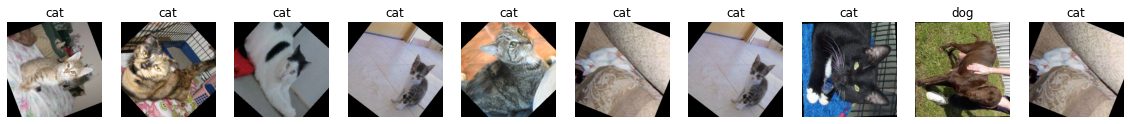

In [11]:
def inverse_normalize(tensor, mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)):
    for t, m, s in zip(tensor, mean, std):
        t.mul_(s).add_(m)
    return tensor


data = DataModule(DATADIR, 16)
n_classes = 2  # len(data.train_dataloader().dataset)
num = min(len(data.dataset_train), 10)

dataset = random.choices(list(data.dataset_train), k=num)
fig, ax = plt.subplots(1, num, figsize=(20, 4), squeeze=False)
for i, (image, label) in enumerate(dataset):
    image = copy.deepcopy(image)
    image_denormalized = inverse_normalize(tensor=image) * 255
    image_denormalized = image_denormalized.short()
    ax[0, i].imshow(image_denormalized.permute(1, 2, 0).cpu())
    ax[0, i].set_title(f"{data.dataset_test.labels[label]}")
    ax[0, i].axis("off")

plt.show()

### Create and train the model

We train the model for five epochs. Since the model uses weights pretrained on ImageNet, this should give good performance if the data is similar to ImageNet data. For other data, you will probably need to increase the `num_epochs` parameter of PyTorch Lightning's `Trainer`.

In [12]:
model = InceptionLightningModel(n_classes, False)
model.datamodule = data
trainer = pl.Trainer(max_epochs=5, gpus=0)
trainer.fit(model)

C:\Users\havanden\code\openvino-notebooks\openvino_env\lib\site-packages\torchvision\models\inception.py:77: FutureWarning: The default weight initialization of inception_v3 will be changed in future releases of torchvision. If you wish to keep the old behavior (which leads to long initialization times due to scipy/scipy#11299), please set init_weights=True.
  ' due to scipy/scipy#11299), please set init_weights=True.', FutureWarning)
GPU available: False, used: False
INFO:lightning:GPU available: False, used: False
TPU available: None, using: 0 TPU cores
INFO:lightning:TPU available: None, using: 0 TPU cores

  | Name   | Type       | Params
--------------------------------------
0 | model  | Inception3 | 21.8 M
1 | metric | Accuracy   | 0     
--------------------------------------
21.8 M    Trainable params
0         Non-trainable params
21.8 M    Total params
87.159    Total estimated model params size (MB)
INFO:lightning:
  | Name   | Type       | Params
--------------------------

Validation sanity check: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

1

### Test the model on the test dataset

The PyTorch Lightning `.test()` method loads the best checkpoint (the checkpoint with the highest accuracy) into the model and returns the accuracy over the test dataset

In [13]:
trainer.test(model, data.test_dataloader, ckpt_path="best")

Testing: 0it [00:00, ?it/s]

--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{'metric': 0.9090909361839294}
--------------------------------------------------------------------------------


[{'metric': 0.9090909361839294}]

#### Show predictions on test dataset

Metrics do not always tell the whole story. Visualizing the results also helps to understand the quality of the model

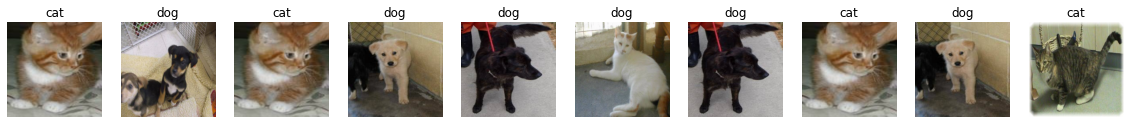

In [14]:
num = min(len(data.dataset_test), 10)

dataset = random.choices(list(copy.deepcopy(data.dataset_test)), k=num)
fig, ax = plt.subplots(1, num, figsize=(20, 5), squeeze=False)
model.eval().cpu()
for i, (image, label) in enumerate(dataset):
    image = copy.deepcopy(image)

    with torch.no_grad():
        prediction = model(image.unsqueeze(0))
    predicted_label = torch.argmax(prediction)
    image = inverse_normalize(image) * 255
    ax[0, i].imshow(image.permute(1, 2, 0).short().cpu())
    ax[0, i].set_title(f"{data.dataset_test.labels[predicted_label]}")
    ax[0, i].axis("off")
plt.show()

## Create OpenVINO Model

To create an OpenVINO IR model, we convert the PyTorch model to ONNX, and then use the OpenVINO model optimizer to convert the ONNX model to an IR model.

In [15]:
modelname = "catdog"
modelname_xml = modelname + ".xml"
modelname_onnx = modelname + ".onnx"

### Create ONNX model

In [16]:
dummy_input = torch.randn(1, 3, 299, 299)
torch.onnx.export(model.model.cpu(), dummy_input, modelname_onnx, opset_version=11)

### Create OpenVINO IR model

In [17]:
subprocess.run(
    [
        sys.executable,  # The Python version that runs this notebooka
        mo_onnx.__file__,  # The path to the `mo_onnx.py` file
        "--model_name",
        modelname,
        "--input_model",
        modelname_onnx,
        "--input_shape",
        "(1,3, 299, 299)",
        "--output_dir",
        os.path.abspath(os.curdir),
        "--data_type",
        "FP16",
    ],
    shell=False,
)

CompletedProcess(args=['C:\\Users\\havanden\\code\\openvino-notebooks\\openvino_env\\Scripts\\python.exe', 'C:\\Users\\havanden\\code\\openvino-notebooks\\openvino_env\\lib\\site-packages\\mo_onnx.py', '--model_name', 'catdog', '--input_model', 'catdog.onnx', '--input_shape', '(1,3, 299, 299)', '--output_dir', 'C:\\Users\\havanden\\code\\openvino-notebooks\\datumaro_openvino', '--data_type', 'FP16'], returncode=0)

### Do inference and show predictions

We create two helper functions, `load_to_IE` and `do_inference` to load the IR model and perform inference. 

We then load the model, do inference on the test dataset, and show the results.

In [18]:
from openvino.inference_engine.ie_api import IECore


def load_to_IE(modelname_xml):
    """
    Load a given IR model to Inference Engine

    :param modelname_xml: Filename to IR model XML file. The accompanying IR bin file is expected to be in the same directory.
    """
    ie = IECore()  # Load the Inference Engine API
    net = ie.read_network(model=modelname_xml, weights=modelname_xml.replace("xml", "bin"))
    exec_net = ie.load_network(network=net, device_name="CPU")  # Load the network to the inference engine
    return exec_net


def do_inference(exec_net, image):
    input_blob = next(iter(exec_net.input_info))
    output_key = next(iter(exec_net.outputs))
    return exec_net.infer({input_blob: image})[output_key]

In [19]:
openvino_model = load_to_IE(modelname_xml)

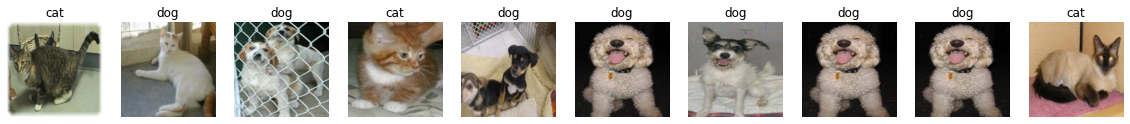

In [20]:
dataset = random.choices(list(copy.deepcopy(data.dataset_test)), k=num)

fig, ax = plt.subplots(1, num, figsize=(20, 5), squeeze=False)
for i, (image, label) in enumerate(dataset):
    image = copy.deepcopy(image)
    input_image = image.unsqueeze(0).float().numpy().copy()
    prediction = do_inference(openvino_model, input_image)
    predicted_label = np.argmax(prediction)

    display_image = inverse_normalize(image) * 255
    ax[0, i].imshow(display_image.permute(1, 2, 0).short().cpu())
    ax[0, i].set_title(f"{data.dataset_test.labels[predicted_label]}")
    ax[0, i].axis("off")
plt.show()

## Compare PyTorch and OpenVINO accuracy and speed

#### Compute accuracy for PyTorch Model

In [21]:
true_labels = []
predicted_labels = []
model.eval().cpu()

for i, (image, label) in enumerate(data.dataset_test):
    image = copy.deepcopy(image)
    input_image = image.unsqueeze(0).float()
    prediction = model(input_image)
    predicted_label = torch.argmax(prediction)
    true_labels.append(label.item())
    predicted_labels.append(predicted_label.item())

torch_score = skm.accuracy_score(true_labels, predicted_labels)
print(f"Accuracy for PyTorch model: {torch_score:.3f}")

Accuracy for PyTorch model: 0.909


#### Compute accuracy for OpenVINO Model

In [22]:
true_labels = []
predicted_labels = []

for i, (image, label) in enumerate(data.dataset_test):
    image = copy.deepcopy(image)
    input_image = image.unsqueeze(0).float().numpy().copy()
    prediction = do_inference(openvino_model, input_image)
    predicted_label = np.argmax(prediction)
    true_labels.append(label.item())
    predicted_labels.append(predicted_label.item())

openvino_score = skm.accuracy_score(true_labels, predicted_labels)

print(f"Accuracy for OpenVINO model: {openvino_score:.3f}")

Accuracy for OpenVINO model: 0.909


#### Compare Inference speed

This gives an initial impression. The OpenVINO speed can be improved by using the Datumaro dataset directly and optimizing the model. CPU info is displayed for context.

In [36]:
get_cpu_info()["brand"]

'Intel(R) Core(TM) i7-1065G7 CPU @ 1.30GHz'

**OpenVINO on CPU (with PyTorch dataset)**

In [33]:
%%timeit
for i, (image, label) in enumerate(data.dataset_test):
    image = copy.deepcopy(image)
    input_image = image.unsqueeze(0).float().numpy().copy()
    prediction = do_inference(openvino_model, input_image)
    predicted_label = np.argmax(prediction)

676 ms ± 14.4 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


**PyTorch on CPU**

In [34]:
%%timeit
model.model.eval().cpu()
for i, (image, label) in enumerate(data.dataset_test):
    image = copy.deepcopy(image)
    with torch.no_grad():
        prediction = model.model(image.unsqueeze(0).cpu())
    predicted_label = torch.argmax(prediction)

2.05 s ± 144 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
